##Muhammad Khubaib Akram 23098929
##Code executes till the end

Code References:
https://pythonprogramming.net/q-learning-reinforcement-learning-python-tutorial/

https://ymd_h.gitlab.io/ymd_blog/posts/gym_on_google_colab_with_gnwrapper/

https://github.com/ageron/handson-ml2/blob/master/18_reinforcement_learning.ipynb

https://gist.github.com/korakot/86f152571f15e921a16af6f916081f40

https://stackoverflow.com/questions/61110188/how-to-display-a-gif-in-jupyter-
notebook-using-google-colab


In [1]:
import sys
assert sys.version_info >= (3,10)

In [ ]:
#!pip install gym==0.26.0


In [2]:
import os
import gym
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np

from keras import models

In [3]:
print(gym.__version__)

0.26.0


In [4]:
from packaging import version
import tensorflow as tf

In [5]:
envs = gym.envs.registry
envs['Pendulum-v1']

EnvSpec(id='Pendulum-v1', entry_point='gym.envs.classic_control.pendulum:PendulumEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='Pendulum', version=1)

In [7]:
new_step_API=True
env = gym.make('Pendulum-v1', render_mode='rgb_array')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
obs, info = env.reset(seed=42)

states = env.observation_space
high_states = env.observation_space.high
low_states = env.observation_space.low

actions = env.action_space
reward_range = env.reward_range

print(states)
print(high_states)
print(low_states)


print(actions)
print(reward_range)

Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
[1. 1. 8.]
[-1. -1. -8.]
Box(-2.0, 2.0, (1,), float32)
(-inf, inf)


# DQN Network

In [9]:
tf.random.set_seed(42)

input_shape = env.observation_space.shape
n_outputs = env.action_space.shape[0]

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="leaky_relu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="leaky_relu"),
    tf.keras.layers.Dense(1, activation='tanh')  # Scaled to [-2, 2] range in the environment step
])



# Added Optimizer to test if the car learns faster in same iterations
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=optimizer, loss='mse')

In [10]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [11]:
def Action(state, epsilon):
    random_number = np.random.rand()
    maxQ_action_count = 0

    if epsilon < random_number:
        # Add a batch dimension to state if using TensorFlow or a similar API
        state_batch = np.expand_dims(state, axis=0)  # Convert state to a batch for prediction
        q_values = 2 * model.predict(state_batch, verbose=0)[0]  # Get Q-values for the state
        action = np.argmax(q_values)  # Choose the best action
        real_action = (action - 4) / 4  # Map to continuous action space
        maxQ_action_count = 1
    else:
        action = np.random.choice([n for n in range(9)])
        real_action = (action - 4) / 2  # Adjust this line if the scaling is intended differently

    return action, real_action, maxQ_action_count

In [12]:
from collections import deque

replay_buffer = deque(maxlen=20000)

In [13]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]  # [states, actions, rewards, next_states, dones, truncateds]

In [14]:
def play_one_step(env, state, epsilon):
    action = Action(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)

    replay_buffer.append((state, action, reward, next_state, done, truncated))


    return next_state, reward, done, truncated, info


In [15]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences

    # Predict the next Q-values with the target network
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = np.max(next_Q_values, axis=1)

    # Calculate the targets
    target_Q_values = rewards + (1 - dones) * discount_factor * max_next_Q_values

    with tf.GradientTape() as tape:
        current_Q_values = model(states)
        # No masking needed, directly compute MSE between predicted and target Q-values
        loss = tf.reduce_mean(loss_fn(target_Q_values, current_Q_values))

    # Compute gradients and apply them
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [33]:
rewards = []
frames_per_episode = []
episode_length = 1000
step_length = 200
best_score = 0
STATS_EVERY = 30

reward_per_episode = []
ep_rewards = []
aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}

for episode in range(episode_length):
    episode_frames  = []
    obs, info = env.reset()
    episode_reward = 0


    episode_rewards = 0
    for step in range(step_length):
        epsilon = max(1 - episode / 500, 0.01)

        frame = env.render()
        if episode == 0 or episode == (episode_length-1):
            episode_frames.append(frame)

        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)

        episode_rewards += reward
        if done:
            # print("Done Step")
            break


    # extra code – displays debug info, stores data for the next figure, and
    #              keeps track of the best model weights so far
        print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}, reward: {reward}, done: {done}, trunc: {truncated}",end="")
        rewards.append(reward)

        if reward >= best_score:
            best_weights = model.get_weights()
            best_score = reward

    reward_per_episode.append(episode_rewards)

    if episode == 0 or episode == (episode_length-1):
        frames_per_episode.append(episode_frames)

    if episode > 50:
        training_step(batch_size)

    ep_rewards.append(episode_reward)

    if not episode % STATS_EVERY:
        average_reward = sum(ep_rewards[-STATS_EVERY:])/STATS_EVERY
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(average_reward)
        aggr_ep_rewards['max'].append(max(ep_rewards[-STATS_EVERY:]))
        aggr_ep_rewards['min'].append(min(ep_rewards[-STATS_EVERY:]))
        print(f'Episode: {episode:>5d}, average reward: {average_reward:>4.1f}')#, current epsilon: {epsilon:>1.2f}')

    # plot_environment(env)
    # plt.show()

model.set_weights(best_weights)  # extra code – restores the best model weights

Episode: 1, Steps: 200, eps: 1.000, reward: -7.451240923019104, done: False, trunc: TrueEpisode:     0, average reward:  0.0
Episode: 31, Steps: 200, eps: 0.940, reward: -3.534373252615699, done: False, trunc: TrueEpisode:    30, average reward:  0.0
Episode: 61, Steps: 200, eps: 0.880, reward: -0.4149907997740995, done: False, trunc: TrueEpisode:    60, average reward:  0.0
Episode: 91, Steps: 200, eps: 0.820, reward: -3.7069378645019, done: False, trunc: TrueEpisode:    90, average reward:  0.0
Episode: 121, Steps: 200, eps: 0.760, reward: -9.345125950707748, done: False, trunc: TrueEpisode:   120, average reward:  0.0
Episode: 151, Steps: 200, eps: 0.700, reward: -3.632485723826647, done: False, trunc: TrueEpisode:   150, average reward:  0.0
Episode: 181, Steps: 200, eps: 0.640, reward: -7.672661720236924, done: False, trunc: TrueEpisode:   180, average reward:  0.0
Episode: 211, Steps: 200, eps: 0.580, reward: -6.9120670510816815, done: False, trunc: TrueEpisode:   210, average re

In [38]:
print(reward_per_episode)

[-1340.2269892568343, -1578.2112006103662, -1505.0176588164777, -1501.3111944230197, -1565.099133257368, -1561.3759813008387, -1577.8630213585664, -1576.8768135444639, -1180.9429769170824, -1280.6879781720263, -1076.9016432536196, -1186.1702864278448, -1452.802839166052, -1064.5975910415773, -1541.2558196688094, -1360.2131670533956, -1322.3192798150692, -1555.640681106982, -1553.860092412501, -1554.2243614175716, -1553.5705179610868, -1571.179619098974, -1572.929209291186, -1177.0303073404855, -1408.9265388374029, -1550.9563902206844, -1159.3610458810817, -1548.371336411519, -1530.7911526278483, -1389.8332766953633, -1563.258135083955, -1511.318019448239, -1518.7589622736396, -1338.4957947976384, -1543.6835563365016, -1182.1992524703674, -1487.4903728942793, -1472.148784820379, -1527.87826524382, -1610.514239326334, -1404.0605782218406, -1471.63077573496, -1188.6289189013341, -1333.7438733751333, -1319.3722221055707, -1555.9415627030392, -1315.6726175296742, -1412.5643111717227, -1269.

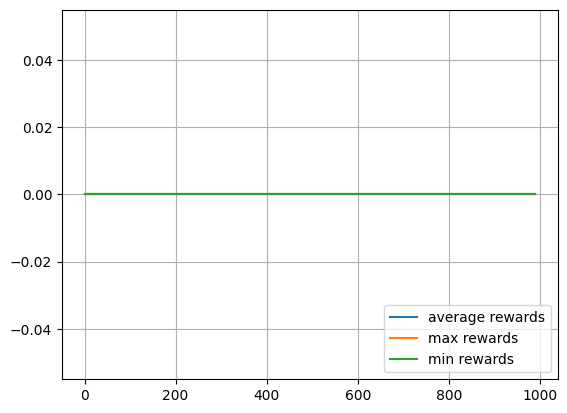

In [34]:
#reward_per_episode
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label="average rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label="max rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label="min rewards")
plt.legend(loc=4)
plt.grid(True)
plt.show()

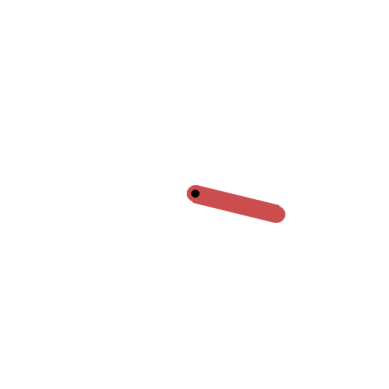

In [35]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter
from IPython.display import HTML

fig, ax = plt.subplots()

def update(frame):
    ax.clear()
    ax.imshow(frame)
    ax.axis('off')  # Hide the axes

# Select which episode to animate
episode_to_animate = 0

ani = FuncAnimation(fig, update, frames=frames_per_episode[episode_to_animate], interval=1)

HTML(ani.to_jshtml())

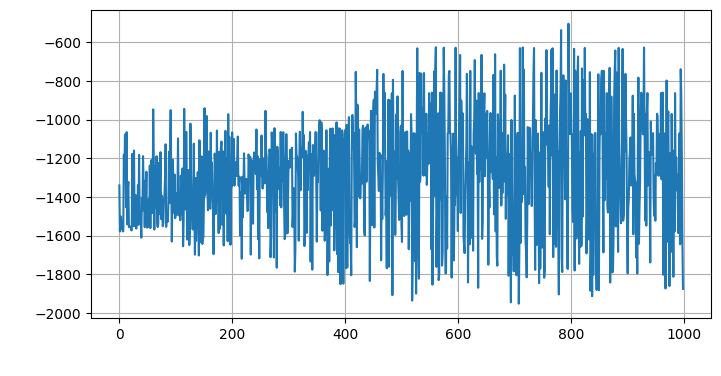

In [37]:
plt.figure(figsize=(8, 4))
plt.plot(reward_per_episode)
plt.xlabel(" ", fontsize=14)
plt.ylabel(" ", fontsize=14)
plt.grid(True)
plt.show()